# S21 simulation and fitting of a resonator

Authors: Samarth Hawaldar, Arvind Mamgain

Adapted from tutorial 4.16


In [1]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
# Analysis
# from qiskit_metal.renderers.renderer_gds.gds_renderer import QGDSRenderer
# from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping
import pyEPR as epr

In [2]:
import numpy as np

# Set up the design

In [3]:
# Set up chip dimensions 
design = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '9mm'
design._chips['main']['size']['size_y'] = '9mm'
design._chips['main']['size']['size_z'] = '-280um'
# Resonator and feedline gap width (W) and center conductor width (S) from reference 2
design.variables['cpw_width'] = '10 um' #S from reference 2
design.variables['cpw_gap'] = '6 um' #W from reference 2


design.overwrite_enabled = True

hfss = design.renderers.hfss

# Open GUI
gui = MetalGUI(design)

In [4]:
# Define for renderer
eig_qres = EPRanalysis(design, "hfss")
#hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# Define the geometry

Here we will have a single feedline couple to a single CPW resonator.

The lauchpad should be included in the driven model simulations.

For that reason, we use the LaunchpadWirebondDriven component which has an extra pin for input/output

In [5]:
###################
# Single feedline #
###################

# Driven Lauchpad 1
x = '-0.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='360', lead_length='30um')
LP1 = LaunchpadWirebondDriven(design, 'LP1', options = launch_options)

# Driven Launchpad 2
x = '0.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='180', lead_length='30um')
LP2 = LaunchpadWirebondDriven(design, 'LP2', options = launch_options)

# coupling resonator to feedline 
q_read = CoupledLineTee(design,'Q_Read_T', options=dict(pos_x = '0.0mm', pos_y = '2mm', 
                                                        orientation = '0',
                                                        coupling_space = '6um',                                                         
                                                        coupling_length = '300um',
                                                        open_termination = False))


gui.rebuild()


In [6]:

# Using path finder to connect the two launchpads
TL_LP1_T = RoutePathfinder(design, 'TL_LP1_T', options = dict(chip='main', trace_width ='10um',
        trace_gap ='6um',
                                            fillet='99um',
                                                                  
        hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='Q_Read_T',
                                                    pin='prime_start')
                                            )))

TL_T_LP2 = RoutePathfinder(design, 'TL_T_LP2', options = dict(chip='main', trace_width ='10um',
        trace_gap ='6um',
                                            fillet='99um',
                                                                  
        hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q_Read_T',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))
# # Rebuild the GUI

In [7]:
######################
# lambda/4 resonator #
######################

# First we define the two end-points
otg = OpenToGround(design, 'otg', options=dict(chip='main', pos_x='0.0mm',  pos_y='0.8mm', orientation='-90'))

# Use RouteMeander to fix the total length of the resonator
rt_meander = RouteMeander(design, 'meander',  Dict(
        trace_width ='10um',
        trace_gap ='6um',
        total_length='3.7mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg', pin='open'),
            end_pin=Dict(component='Q_Read_T', pin='second_end')), ))

# rebuild the GUI
gui.rebuild()

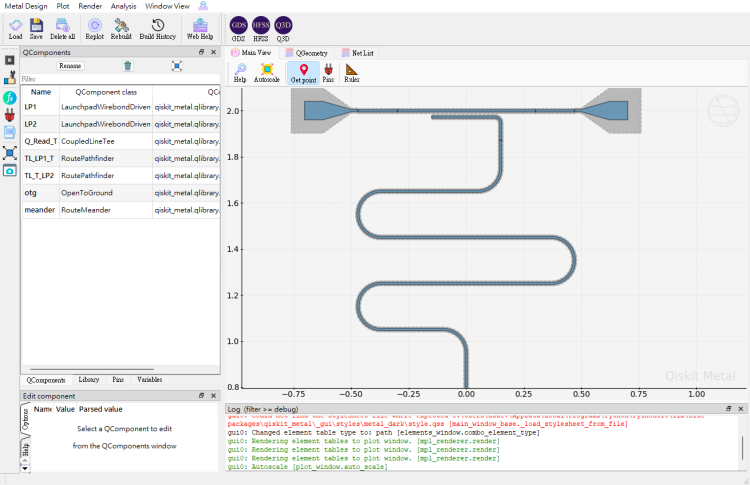

In [8]:
gui.autoscale()
gui.screenshot()

# Scattering Analysis

In [9]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [10]:
design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin LP1_in and LP2_in are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('LP1', 'in', 50),
             ('LP2', 'in', 50)]
box_plus_buffer = True

In [11]:
em1.setup.name = "Sweep_DrivenModal_setup"
em1.setup.freq_ghz = 6.0 # Try to keep this at the center of the swept frequency range for 'fast' sweeps and at the largest frequency for interpolating sweep for the best results
em1.setup.max_delta_s = 0.005 # This is necessary to get good results if interpolating sweep is not working for you
em1.setup.max_passes = 18
em1.setup.min_passes = 2
em1.setup.basis_order = -1 # Mixed order
em1.setup

{'name': 'Sweep_DrivenModal_setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 6.0,
 'max_delta_s': 0.005,
 'max_passes': 18,
 'min_passes': 2,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': -1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2.0,
  'stop_ghz': 8.0,
  'count': 101,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

In [12]:
# we use HFSS as rendere
hfss = em1.renderer
hfss.start()

INFO 02:04PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:04PM [load_ansys_project]: 	Opened Ansys App
INFO 02:04PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 02:04PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/askev/OneDrive/文件/Ansoft/
	Project:   Project3
INFO 02:04PM [connect_design]: No active design found (or error getting active design).
INFO 02:04PM [connect]: 	 Connected to project "Project3". No design detected


True

In [13]:
# set buffer
hfss.options['x_buffer_width_mm'] = 0.1
hfss.options['y_buffer_width_mm'] = 0.1

In [14]:
# clean the design if needed
hfss.clean_active_design()

AttributeError: 'NoneType' object has no attribute 'modeler'

In [ ]:
# render the design
em1._render(selection=[],
                    solution_type='drivenmodal',
                    vars_to_initialize=em1.setup.vars, 
                    open_pins=open_terminations, 
                    port_list=port_list, 
                    box_plus_buffer = box_plus_buffer)

In [15]:
#for accurate simulations, make sure the mesh is fine enough for the meander
hfss.modeler.mesh_length(
                'cpw_mesh',
                ['trace_meander'],
                MaxLength='0.05mm')

AttributeError: 'NoneType' object has no attribute 'mesh_length'

# Broad sweet to find the resonance

In [ ]:
em1.setup.sweep_setup.start_ghz = 4.0
em1.setup.sweep_setup.stop_ghz = 8.0
em1.setup.sweep_setup.count = 10001
em1.setup.sweep_setup.type = "Fast"
em1._analyze() # This is necessary to keep the changes made to max_delta_s and min_passes

In [16]:
hfss.plot_params(['S21'])
# make sure that you can see a dip in S21. If not, change the frequency sweep region or decrease the MaxLength of the mesh and retry.
# Or you can even try an interpolating sweep

UnboundLocalError: local variable 'freqs' referenced before assignment

In [ ]:
hfss.get_convergences() # Make sure that it converges

In [17]:
# extract the S21 parameters
freqs, Pcurves, Pparams = hfss.get_params(['S21'])
# find argmin 
f_res = freqs[np.argmin(np.abs(Pparams.S21.values))]
f_res # If the dip at f_res is not deep enough to be the minimum in the plot, try to eyeball its location and set it here. A better way would be to use scipy's find_peaks functionality

UnboundLocalError: local variable 'freqs' referenced before assignment

# Narrow sweep around the resonance found above

In [ ]:
em1.setup.sweep_setup.start_ghz = np.round(f_res/1e9,5)-0.05
em1.setup.sweep_setup.stop_ghz = np.round(f_res/1e9,5)+0.05
em1._analyze()

In [18]:
hfss.plot_params(['S21'])

UnboundLocalError: local variable 'freqs' referenced before assignment

In [ ]:
freqs, Pcurves, Pparams = hfss.get_params(['S21'])

In [19]:
# find argmin
f_res = freqs[np.argmin(np.abs(Pparams.S21.values))]
f_res

NameError: name 'freqs' is not defined

# Very-Narrow sweep around the resonance found above

In [ ]:
em1.setup.sweep_setup.start_ghz = np.round(f_res/1e9,5)-0.005
em1.setup.sweep_setup.stop_ghz = np.round(f_res/1e9,5)+0.005
em1._analyze()

In [20]:
hfss.plot_params(['S21'])

UnboundLocalError: local variable 'freqs' referenced before assignment

In [ ]:
freqs, Pcurves, Pparams = hfss.get_params(['S21'])

In [21]:
from qiskit_metal.analyses.em.transmission_fitting import fit_transmission

In [22]:
fit_transmission(freqs,Pparams.S21.values) # This fits the transmission, plots the fit over the raw data, and returns only the parameters best fit parameters and plots

NameError: name 'freqs' is not defined

In [ ]:
# This fits the transmission, but does not generate the plot. Also, returns the fit parameters as a vector and the associated covariance matrix
fit_dict, _, fit_vec, fit_cov = fit_transmission(freqs,Pparams.S21.values, full_output=True, plot=False)

# To obtain the standard deviations from the covariance matrix, use the below
np.sqrt(np.diag(fit_cov))

# Close connections

In [ ]:
#from qiskit_metal import q13

In [23]:
em1.close()

AssertionError: It does not appear that you have connected to HFSS yet.            Use the connect()  method. 🤢

In [ ]:
hfss.disconnect_ansys()

In [24]:
#gui.main_window.close()